## Electricity demand - Clustering

## Project Overview

* We will explore a dataset and carry out clustering using k-means algorithm

* Identify the optimum number of clusters for a given dataset

- Problem Description: 
We will study the electricity demand from clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

We will use clustering techniques to understand the typical usage behaviour during 2013-2014.

Both these datasets are publicly available, and can be used to carry out experiments. Their source is below:

 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm

## Data Preparation

In [1]:
pathToFile = r"C:\\Users\\Ivian\\Documents\\DS Certificate\\Machine Learning\\"
#pathToFile = r"C:\\Users\\<your username>\\Downloads\\"

fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
random.seed(42)

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [7]:
data.shape

(140256, 370)

- As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [9]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


- Plot the first 2 days of 2012 for the first 2 clients

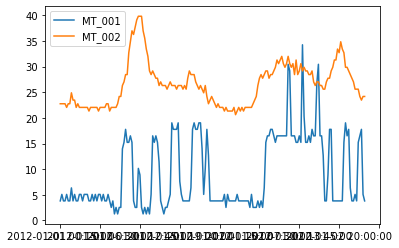

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

- We  note that the main difference between the curves is the level (also seen on the means in df.describe()).  We know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [15]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [16]:
data['hour'] = data.index.map(lambda x: x[11:])

In [17]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [18]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [19]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

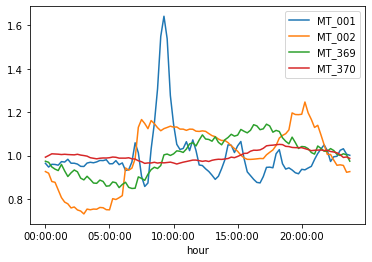

In [20]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [21]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format

- Determine what a convenient number of clusters would be. We will make use of the sklearn's package for k-means for this.

In [22]:
#get_inertia function taken from the module 04 notebook

def get_inertia(X,kmeans):
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [23]:
#getting inertia and silhouette scores

inertia_scores = []
silhouette_scores = []
min_num_cluster = 2
max_num_cluster = 20

for n_clusters in range(min_num_cluster,max_num_cluster+1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia_scores.append(get_inertia(X, kmeans))
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

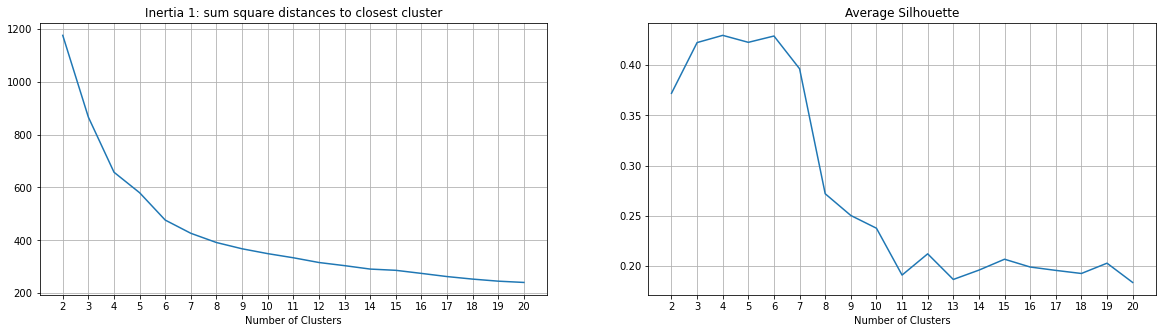

In [24]:
# Plot
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Inertia 1: sum square distances to closest cluster")
plt.plot(np.arange(min_num_cluster,max_num_cluster+1),inertia_scores)
plt.xticks(np.arange(min_num_cluster,max_num_cluster+1))
plt.xlabel('Number of Clusters')
plt.grid()

plt.subplot(1,2,2)  
plt.title("Average Silhouette")
plt.plot(np.arange(min_num_cluster,max_num_cluster+1), silhouette_scores)
plt.xticks(np.arange(min_num_cluster,max_num_cluster+1))
plt.xlabel('Number of Clusters')
plt.grid()

plt.show()

Considering the plots above, we can see that the optimal number of clusters would be probably be 5 or 6.

The inertia does not decrease as much after 6 clusters and the silhouette also does not increase anymore.
We can then analyze the inertia with respect to the second closest center and/or visialuzi the clusters after reducing the dimensionality.

In [25]:
#getting the inertia with respect to the closes center
def getInertia2(X,kmeans):
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2

In [26]:
inertia_2_scores = []

for n_clusters in range(min_num_cluster,max_num_cluster+1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia_2_scores.append(getInertia2(X, kmeans))

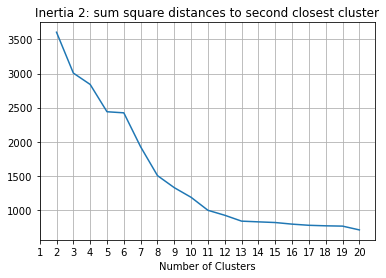

In [27]:
plt.title("Inertia 2: sum square distances to second closest cluster")
plt.plot(np.arange(min_num_cluster,max_num_cluster+1),inertia_2_scores)
plt.xticks(np.arange(1,max_num_cluster+1))
plt.xlabel('Number of Clusters')
plt.grid()

In [28]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

def vis_n_clusters(num_clusters, X):

    kmeans = KMeans(n_clusters=num_clusters, random_state=123).fit(X)
    labels = kmeans.labels_
    
    plt.figure(figsize=(20,5))
    
    # TSNE
    plt.subplot(1,2,1)
    tsne_t = TSNE(n_components=2, random_state=123).fit_transform(X)
    plt.scatter(x = tsne_t[:,0],y = tsne_t[:,1], c=labels)
    plt.title('TSNE Embedding Clusters')
    
    # PCA
    plt.subplot(1,2,2)
    pca_t = PCA(n_components=2, random_state=123).fit_transform(X)
    plt.scatter(x = pca_t[:,0],y = pca_t[:,1], c=labels)
    plt.title('PCA Clusters')
    
    plt.show()

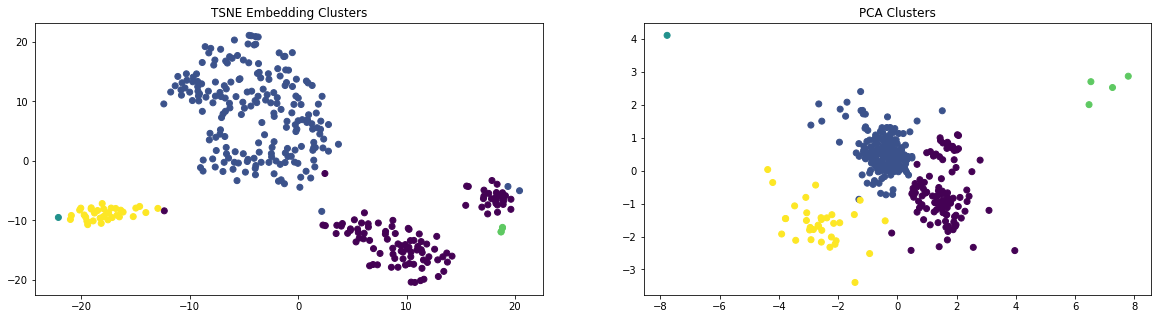

In [29]:
vis_n_clusters(5, X)

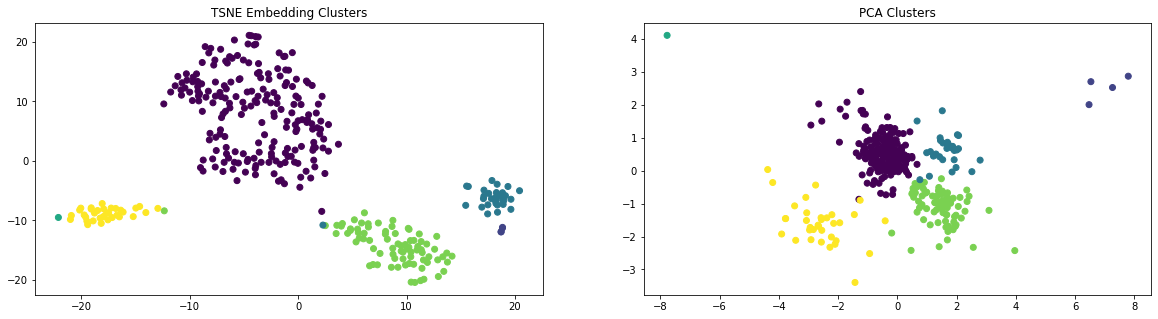

In [30]:
vis_n_clusters(6, X)

From inertia 2 plot and the clusters plot, we can see that 6 clusters is slightly better in terms of both inertia and better clusters in different dimensional spaces. We will proceed with 6 clusters.

- We will make a plot for each cluster, that includes:
    - The number of clients in the cluster
    - All the curves in the cluster
    - The curve corresponding to the center of the cluster (make this curve thicker to distinguish it from the individual curves).  The center is also sometimes referred to as "centroid".

In [31]:
#Plotting the clusters
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
unique_clusters = np.unique(labels)

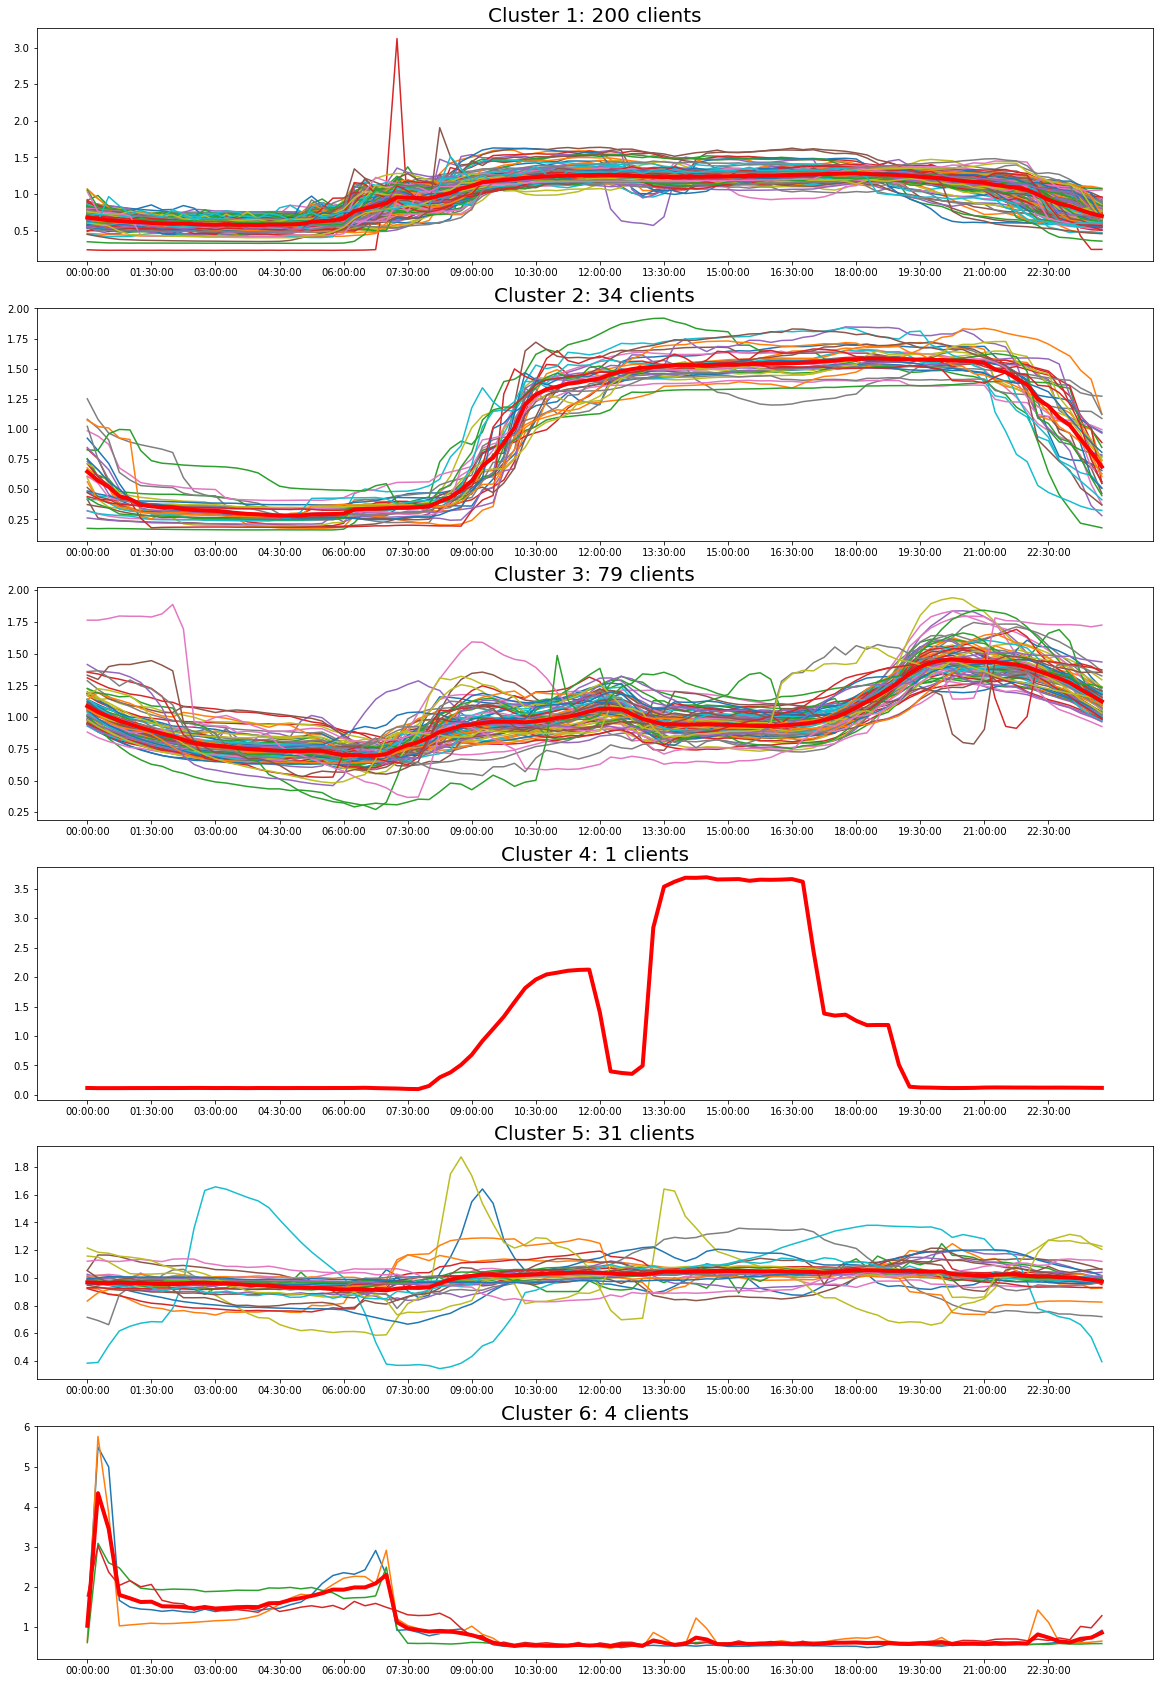

In [32]:
fig = plt.figure(figsize=(20,30))

for cluster in unique_clusters:
    fig.add_subplot(len(unique_clusters),1,cluster+1)
    cluster_x = []
    for i,j in enumerate(labels):
        if j == cluster:
            cluster_x.append(i)
    plt.plot(average_curves_norm.iloc[:,cluster_x])
    plt.plot(centers[cluster],c='red',linewidth=4.0)
    plt.xticks(average_curves_norm.index.values[::(len(unique_clusters-1))])
    plt.title("Cluster {0}: {1} clients".format(cluster + 1, len(cluster_x)),size=20.0)

plt.show()  

From the plots above, it seems like clusters 1, 2 and 3 have similar shapes for the clients plotted in the cluster. Cluster 4 seems to be a single outlier that has a different shape from the others. Cluster 5 has less clients with a different shape than the first clusters and Cluster 6 does not seem to have a noticeable trend.

**Daily Curves of 1 single client**

First, we will create a list of arrays, each array containing a curve for a day.
    X = average_curves_norm.copy() 
The list contains 730 arrays, one for each of the days of 2013 and 2014.

In [33]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

- The following cell generates a list of all the days in the two years 2013-2014


In [34]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

- The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3].

In [35]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

In [36]:
#repeating the process
inertia_scores = []
silhouette_scores = []
min_num_cluster = 2
max_num_cluster = 20

for n_clusters in range(min_num_cluster,max_num_cluster+1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia_scores.append(get_inertia(X, kmeans))
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

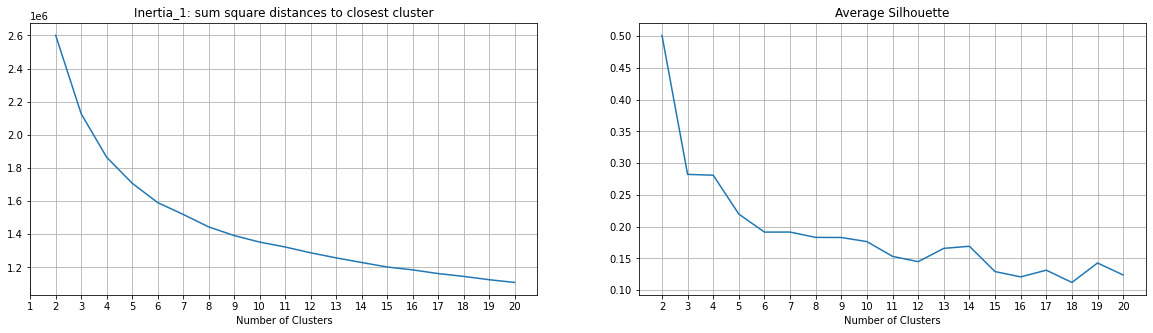

In [37]:
# Plot
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(min_num_cluster,max_num_cluster+1),inertia_scores)
plt.xticks(np.arange(1,max_num_cluster+1))
plt.xlabel('Number of Clusters')
plt.grid()

plt.subplot(1,2,2)  
plt.title("Average Silhouette")
plt.plot(np.arange(min_num_cluster,max_num_cluster+1), silhouette_scores)
plt.xticks(np.arange(min_num_cluster,max_num_cluster+1))
plt.xlabel('Number of Clusters')
plt.grid()

plt.show()

Considering the plots above, we can see that the optimal number of clusters would be probably be 3 or 4.
It seems that the inertia continues to get slightly better even after 4 clusters, but from the silhouette we can probably go with 4. We can proceed and analyze the inertia 2 scores and clusters plot.

In [38]:
inertia_2_scores = []

for n_clusters in range(min_num_cluster,max_num_cluster+1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia_2_scores.append(getInertia2(X, kmeans))

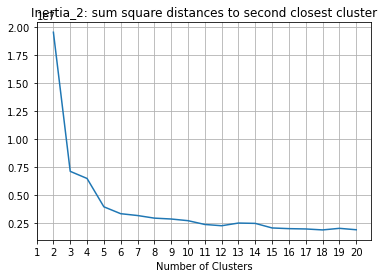

In [39]:
plt.title("Inertia_2: sum square distances to second closest cluster")
plt.plot(np.arange(min_num_cluster,max_num_cluster+1),inertia_2_scores)
plt.xticks(np.arange(1,max_num_cluster+1))
plt.xlabel('Number of Clusters')
plt.grid()

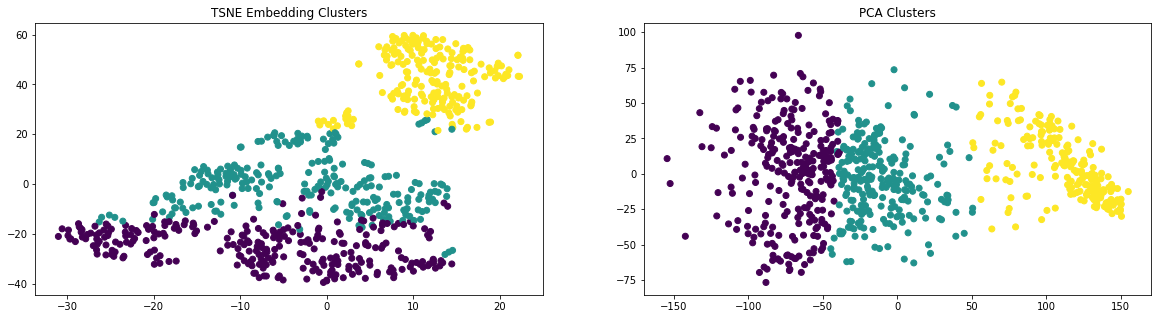

In [40]:
vis_n_clusters(3, X)

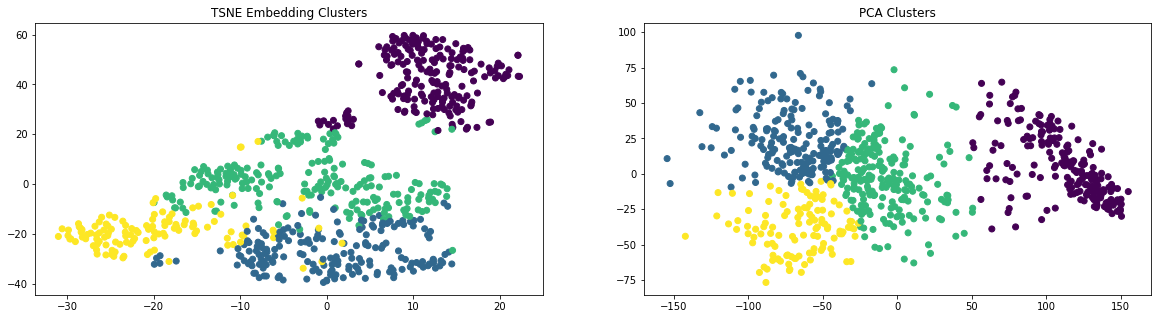

In [41]:
vis_n_clusters(4, X)

It seems that the inertia 2 does not get much better after 3 clusters and based on the cluster visualization we can proceed with 3 clusters.

In [42]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
unique_clusters = np.unique(labels)
unique_clusters

array([0, 1, 2])

In [43]:
dfX = pd.DataFrame(X).T
dfX['hour'] = average_curves_norm.index.values
dfX = dfX.set_index('hour')

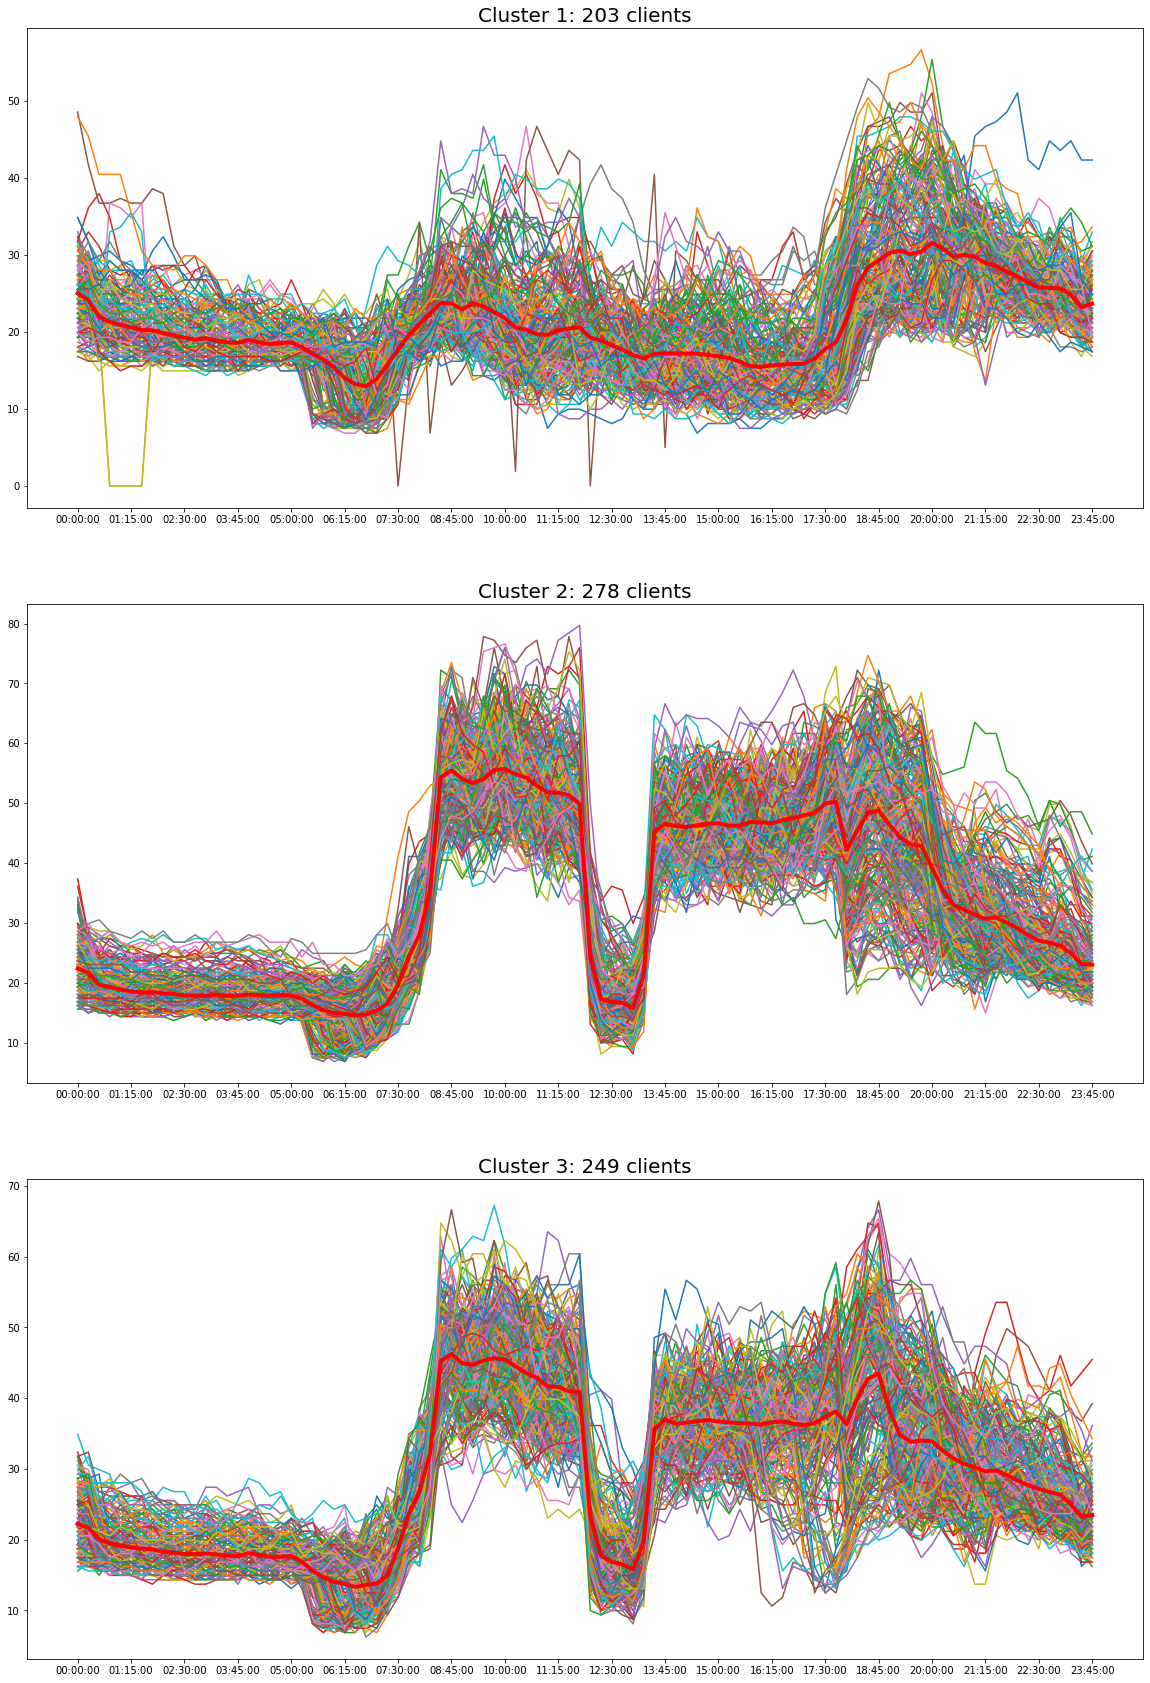

In [44]:
fig = plt.figure(figsize=(20,30))

for cluster in unique_clusters:
    fig.add_subplot(len(unique_clusters),1,cluster+1)
    cluster_x = []
    for i,j in enumerate(labels):
        if j == cluster:
            cluster_x.append(i)
    plt.plot(dfX.iloc[:,cluster_x])
    plt.plot(centers[cluster],c='red',linewidth=4.0)
    plt.xticks(dfX.index.values[::5])
    plt.title("Cluster {0}: {1} clients".format(cluster + 1, len(cluster_x)),size=20.0)

plt.show()

It looks like every cluster has a decent amount of clients and the plots follow similar shapes and are consistent. We can also see that Cluster 1 looks more consistent in terms of consumption (does not change as much) and the other two clusters follow similar patterns. We can investigate this more to understand how the clusters were defined.

In [45]:
#Creating a dataframe for better visualization and analyze later in terms of days, months, etc
unique_clusters = np.unique(kmeans.labels_)
labels = kmeans.labels_
entries = []
for cluster in unique_clusters:
    label_indexes = np.squeeze(np.argwhere(labels == cluster))
    days_in_cluster = np.array(daysyear)[label_indexes]
    entries_in_cluster = np.array(X)[label_indexes]
    days_in_cluster = [pd.to_datetime(d) for d in days_in_cluster]
    for day, entires in zip(days_in_cluster, entries_in_cluster):
        mean = np.mean(entires)
        std = np.std(entires)
        entries.append([cluster, day, mean, std])
    
cluster_df = pd.DataFrame(entries, columns=['cluster', 'day', 'mean', 'std']) 

In [46]:
cluster_df.head(2)

,cluster,day,mean,std
0,0,2013-01-01,22.675384,5.641813
1,0,2013-01-05,24.536893,9.774625


In [47]:
#Creating columns for day of week, month and year
import calendar
cluster_df['day_of_week'] = cluster_df['day'].dt.day_name(locale = 'English')
cluster_df['month'] = cluster_df['day'].dt.month_name(locale = 'English')
cluster_df['year'] = cluster_df['day'].dt.year
cluster_df.head(2)

,cluster,day,mean,std,day_of_week,month,year
0,0,2013-01-01,22.675384,5.641813,Tuesday,January,2013
1,0,2013-01-05,24.536893,9.774625,Saturday,January,2013


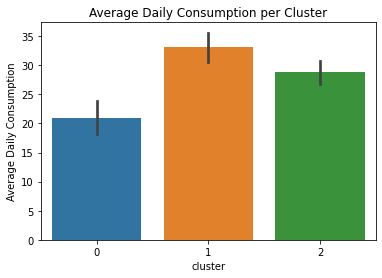

In [48]:
#Average consumption per cluster
ax = sns.barplot(x="cluster", y='mean', ci='sd', data=cluster_df)
ax.set(ylabel='Average Daily Consumption')
ax.set_title('Average Daily Consumption per Cluster');

Cluster 0 has the smallest average consumption, and the other two cluster have similar values, but Cluster 1 has the highest average consumption.

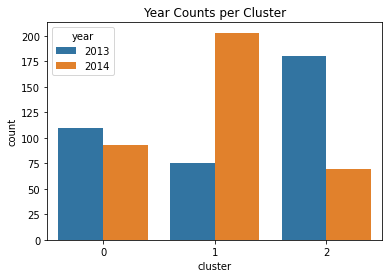

In [49]:
#Plotting by year
ax = sns.countplot(x="cluster", hue='year', data=cluster_df)
ax.set_title('Year Counts per Cluster');

Cluster 0 is fairly distributed, but Cluster 1 has more 2014 data and Cluster 2 has more 2013 data. Maybe these clusters are getting some consumption variation that happened from one year to the next.

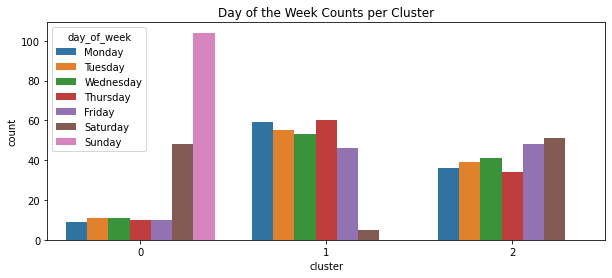

In [50]:
#Analyzing per week day
hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x="cluster", hue='day_of_week', hue_order=hue_order, data=cluster_df, ax=ax)
ax.set_title('Day of the Week Counts per Cluster');

This plot gives a better idea in terms of day of the week distribution. Cluster 0 includes mostly weekends (it could be that the remaining week days are holidays). Cluster 1 includes mostly weekdays and Cluster 2 is fairly distributed from Monday to Saturday.

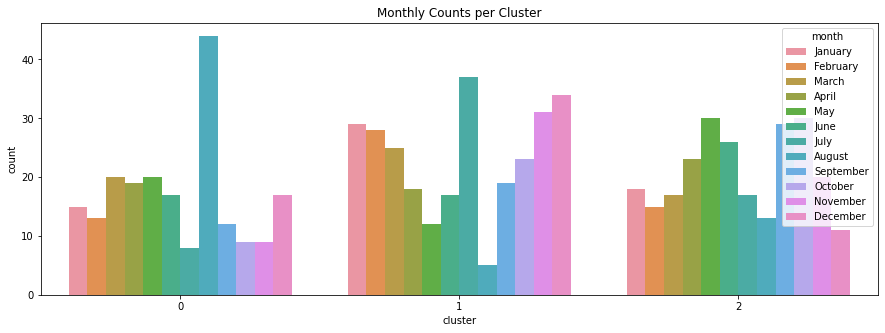

In [51]:
#Analyzing in terms of months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(ax=ax, x="cluster", hue='month', hue_order=months, data=cluster_df)
ax.set_title('Monthly Counts per Cluster');

In [52]:
#Creating a column for season
cluster_df['season'] = (cluster_df['day'].dt.month%12 + 3)//3

seasons = {
             1: 'Winter',
             2: 'Spring',
             3: 'Summer',
             4: 'Autumn'
}

cluster_df['season_name'] = cluster_df['season'].map(seasons)

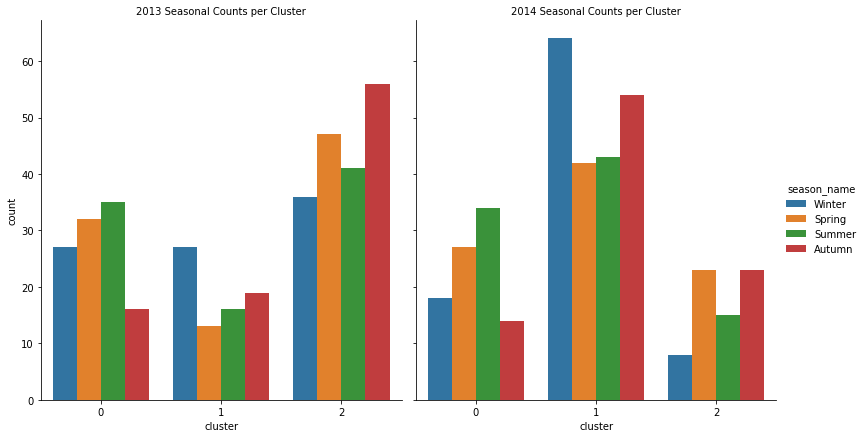

In [53]:
#Analyzing in terms of season
g = sns.catplot(x="cluster", hue="season_name", col="year",
                 data=cluster_df, kind="count",
                 height=6, aspect=.9);
g.set_titles("{col_name} Seasonal Counts per Cluster");

It seems like Cluster 0 is fairly distributed over the year with peak in August and consist mostly of weekends. Cluster 1 contains more 2014 data, weekdays and winter/autumn data. Cluster 2 contains more 2013 data spread over Mon-Sat and spring/autumn data. We can also see that Cluster 2 has a slight peak of consumption around 7pm whereas Cluster 1 tends to usually decrease in the afternoon/evening. It could be the case that if we had 2 clusters the data will be distributed by weekends/weekdays.